# Synthetic Data Quality Evaluation

In [1]:
# import libraries
import os
os.chdir("..")
import torch
import pandas as pd
import numpy as np
import PIL
from PIL import Image
from torchvision.utils import make_grid
from torchvision import transforms
from matplotlib import pyplot as plt
from utils.data_utils import ImageDataset
import seaborn as sns
from tqdm import tqdm

## Load Data

In [11]:
synthetic_dataset_path = "/home/zchayav/projects/syntheye/synthetic_datasets/all_folds/stylegan2_synthetic_300perclass/generated_examples.csv"
real_dataset_path = "/home/zchayav/projects/syntheye/datasets/eye2gene_new_filepaths/all_baf_valid_50deg_filtered_train_0_edited.csv"

# add image transforms
tr = transforms.Compose([transforms.Resize((299, 299)), transforms.Grayscale(3), transforms.ToTensor()])

# load csvs
synthetic_dataset = ImageDataset(synthetic_dataset_path, "file.path", "gene", class_vals="classes.txt", transforms=tr, class_mapping="classes_mapping.json")
real_dataset = ImageDataset(real_dataset_path, "file.path", "gene", class_vals="classes.txt", transforms=tr, class_mapping="classes_mapping.json")
synth_dataloader = torch.utils.data.DataLoader(synthetic_dataset, batch_size=128)
real_dataloader = torch.utils.data.DataLoader(real_dataset, batch_size=128)

In [ ]:
# sample_images = torch.cat([synthetic_dataset[i][2] for i in range(25)], dim=0)
# sample_images = sample_images[:, None, :, :]
# assert sample_images.shape == (25, 1, 512, 512)

# plt.figure(figsize=(6, 6))
# grid = make_grid(sample_images, nrow=5)
# plt.imshow(grid.numpy().transpose(1, 2, 0))
# plt.axis('off')
# plt.show()

## Feature Space Analysis

In [15]:
# del model_weights, model

# load inceptionv3 trained on real data
from torchvision.transforms import Grayscale
from torchvision.models import inception_v3
model_weights = torch.load("/home/zchayav/projects/syntheye/eye2gene_retraining/inception_model/all_folds_retraining/real_only/best_weights.pth")
# load architecture
model = inception_v3()
model.AuxLogits.fc = torch.nn.Linear(768, 36)
model.fc = torch.nn.Linear(2048, 36)
# load weights
model.load_state_dict(model_weights)
# replace last layer with identity layer
model.fc = torch.nn.Identity()
# add on GPU
model.to("cuda:1")
model.eval()

# get feature maps of all images
real_features = []
synthetic_features = []

for _, _, x, y in tqdm(real_dataloader):
    x = x.to("cuda:1")
    real_features.append(model(x).detach().cpu().numpy())

for _, _, x, y in tqdm(synth_dataloader):
    x = x.to("cuda:1")
    synthetic_features.append(model(x).detach().cpu().numpy())

real_features = np.concatenate(real_features, axis=0)
synthetic_features = np.concatenate(synthetic_features, axis=0)

100%|██████████| 85/85 [01:06<00:00,  1.28it/s]


In [37]:
# embed the real dataset in 2D
def run_dim_reduce(data, n_components=2, method="tsne", transform=False, **extra_params):

    reals, synths = data

    if method == "umap":
        import umap
        n_neighbours = extra_params["n_neighbors"] if "n_neighbors" in extra_params.keys() else 15
        min_dist = extra_params["min_dist"] if "min_dist" in extra_params.keys() else 0.1

        print("Fitting Real Dataset")
        real_reducer = umap.UMAP(n_neighbors=n_neighbours, min_dist=min_dist, random_state=1399, n_components=n_components)
        if isinstance(reals, torch.utils.data.dataloader.DataLoader):
            for _, _, x, y in tqdm(real_dataloader):
                x = x.view(len(x), -1).numpy()
                real_reducer.fit(x)
        else:
            real_reducer.fit(reals)

        print("Fitting Synthetic Dataset")
        synth_reducer = umap.UMAP(n_neighbors=n_neighbours, min_dist=min_dist, random_state=1399, n_components=n_components)
        if isinstance(synths, torch.utils.data.dataloader.DataLoader):
            for _, _, x, y in tqdm(synth_dataloader):
                x = x.view(len(x), -1).numpy()
                synth_reducer.fit(x)
        else:
            synth_reducer.fit(synths)

    else:
        from sklearn.manifold import TSNE
        print("Fitting Real Dataset")
        real_reducer = TSNE(n_components=n_components, init='random', random_state=1399)
        if isinstance(reals, torch.utils.data.dataloader.DataLoader):
            for _, _, x, y in tqdm(real_dataloader):
                x = x.view(len(x), -1).numpy()
                real_reducer.fit(x)

        print("Fitting Synthetic Dataset")
        synth_reducer = TSNE(n_components=n_components, init='random', random_state=1399)
        if isinstance(synths, torch.utils.data.dataloader.DataLoader):
            for _, _, x, y in tqdm(synth_dataloader):
                x = x.view(len(x), -1).numpy()
                synth_reducer.fit(x)  

    if transform:
        if isinstance(reals, torch.utils.data.dataloader.DataLoader):
            real_embed = []
            for _, _, x, y in real_dataloader:
                real_embed.append(real_reducer_2d.transform(x.view(len(x), -1)))
            real_embed = np.concatenate(real_embed)
        else:
            real_embed = real_reducer.fit_transform(np.float32(reals))

        if isinstance(synths, torch.utils.data.dataloader.DataLoader):
            synth_embed = []
            for _, _, x, y in synth_dataloader:
                synth_embed.append(synth_reducer_2d.transform(x.view(len(x), -1)))
            synth_embed = np.concatenate(synth_embed)
        else:
            synth_embed = synth_reducer.fit_transform(np.float32(synths))

        return (real_reducer, synth_reducer, real_embed, synth_embed)
    else:
        return (real_reducer, synth_reducer)

In [44]:
# run 2d dimensionality reduction algorithm
_, _, real_features_2d, synthetic_features_2d = run_dim_reduce((real_features, synthetic_features), n_components=2, method="umap", transform=True, n_neighbors=25, min_dist=0.99)

Fitting Real Dataset
Fitting Synthetic Dataset


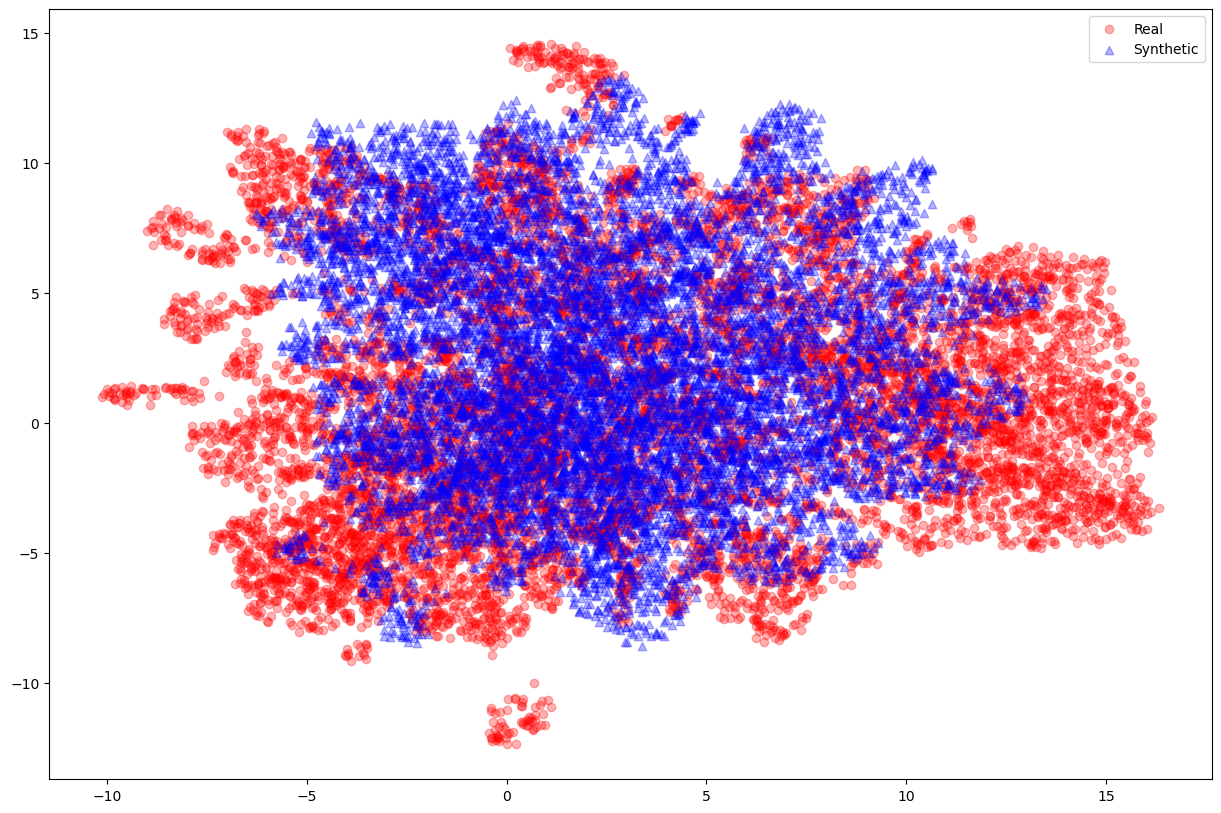

In [46]:
y = np.array([real_dataset.class2idx[i] for i in real_dataset.img_labels])
y_synth = np.array([synthetic_dataset.class2idx[i] for i in synthetic_dataset.img_labels])
target_names = list(real_dataset.class2idx.keys())
target_ids = list(real_dataset.class2idx.values())
assert len(target_names) == len(target_ids)
assert real_features_2d.shape[0] == len(y)
assert synthetic_features_2d.shape[0] == len(y_synth)

plt.figure(figsize=(15,10))
# for i, label in zip(target_ids, target_names):
#     plt.scatter(real_features_2d[y == i, 0], real_features_2d[y == i, 1], label=label)
#     plt.scatter(synthetic_features_2d[y_synth == i, 0], synthetic_features_2d[y_synth == i, 1], label=label)

plt.scatter(real_features_2d[:, 0], real_features_2d[:, 1], c="red", marker="o", alpha=0.3)
plt.scatter(synthetic_features_2d[:, 0], synthetic_features_2d[:, 1], c="blue", marker="^", alpha=0.3)
plt.legend(["Real", "Synthetic"], loc='upper right')
plt.show()
plt.close()